## Planner-Executer architecture:

It is a type of the arcitecture where the system first of all computes and thinks of a sequence of task/step to perform to achieve the goal before even starting to execute the first step. It gets ready for battle without starting it. It first of all makes a breif sequence of step the system has to follow to achieve goalm where the steps are the simple sub-goals that are made from the main complex goal.

It is different from ReAct architecture as ReAct is for one step reasoning(step) as a time where as this is for plan once and reach the goal with the steps in the plan. ReAct is done for the goal that is lighter than the goal given to planner-executer as we dont have to reason more in ReaAct and ReAct is high bill generator as we have to keep reasoning as the goal gets complex which consumes high token eventually leading to high cost.

### Components of planner architecture:

It contains of two components:

1. planner: the one that makes the plan by decomposing the goal into sub-gials that are simple and can be executed with 1 or 2 tool calls
2. executor : the one that reads the plan step-by-step and executes the task and eventually reaches the goal.

we still have the loop between the agent and the tools but the agent is executor that will execute the plan step by step


If we have multiple executor agent based upon the task then we would distribute the task based upon the task
Planner can be Multi-Agent system or may not be one.

In [ ]:
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, BaseMessage, SystemMessage, AIMessage, ToolMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3
from typing import TypedDict, Annotated, List, Tuple, Any, Optional
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
import os

In [ ]:
load_dotenv()
parser = StrOutputParser()

In [ ]:
model1 = ChatGroq(
    model=os.getenv("model"),
    api_key=os.getenv("api_key")
)

model2 = ChatGroq(
    model=os.getenv("model"),
    api_key=os.getenv("api_key")
)


tavily_tool = TavilySearch(max_results=1, topic='general', include_answer=True)

tavily_tool.invoke({'query' : "What are the latest breakthroughs in AI for 2026?"})

In [ ]:
class PlanExecute(TypedDict):
    goal : str
    plan : Annotated[list[BaseMessage], add_messages]
    answer : Annotated[list[AIMessage], add_messages] #this will contain the final answer
    intermediate_steps : Annotated[ List[Tuple[Any, Any, Optional[Any]]], add_messages] #this will contain the intermediate plan answer like query, tool_calls, and ai messge

class Output(BaseModel):
    output : list[str] = Field(description="this should contain the list of the steps to follow to acheicve the goal")

output_format = PydanticOutputParser(pydantic_object=Output)

model2.bind_tools([tavily_tool])

tools = [tavily_tool]
tools_by_name = {tool.name: tool for tool in tools}
tools_by_name

## Planner Agent:

In [ ]:
def planner(state: PlanExecute):
    goal = state["goal"]
    template = PromptTemplate(template="""For the given objective, come up with a simple step by step plan. The plan should contains only the steps or the question to be asked to the other llm and t should not contain the asnwer. \
    This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
    The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps. 
    goal: {goal} \n\n 
    the format of the plan made should be : {format_ins}""", input_variables=['goal'], partial_variables={"format_ins" : output_format.get_format_instructions()})
    chain = template | model1 | output_format
    output = chain.invoke(goal).output
    print("the plan is")
    print(output)
    return {'plan' : [output]}


In [ ]:
planner(PlanExecute(goal="What is the population of the capital city of France? "))

## Executor Agent:

In [ ]:
def executer(state : PlanExecute):
    print("hello")
    plan = state['plan']
    intermediate_step = state.get("intermediate_steps")
    print(intermediate_step)
    if intermediate_step == None:
        intermediate_step = []
    current_plan = plan[0]
    output = model2.invoke(f"""You are an Executor Agent.

        You receive:
        1. A task or objective
        2. A finalized plan generated earlier
        3. Any intermediate answers, decisions, or context from previous steps

        Your responsibilities:
        - Execute the task strictly according to the given plan.
        - Use previous answers and context whenever required.
        - Perform any necessary computation, tool usage, or synthesis.
        - If execution is not required, directly provide the final answer.

        Rules:
        - Do NOT explain your reasoning.
        - Do NOT show chain-of-thought, analysis, or internal decision-making.
        - Do NOT restate the plan unless explicitly asked.
        - Output ONLY the final result, solution, or answer.
        - Be concise, correct, and execution-focused.
                                

                plan: {current_plan},
                precious step: {intermediate_step}
                                

        If information is missing:
        - Make the minimal reasonable assumption and proceed.
        - Do NOT ask clarifying questions unless execution is impossible.

        Output format:
        - Final answer only.
        - No markdown headings, no explanations, no meta-comments.""").content
    intermediate_step.append((current_plan, output))
    print(intermediate_step)
    # keeps on executing the plans
    plan = plan[1:]
    return {'intermediate_steps' : [intermediate_step], 'plan' : [plan]}

In [ ]:
executer(PlanExecute(plan=['What is the capital city of France?','What is the population of the city identified in the previous step?'], intermediate_steps=[]))

In [ ]:
def condition_check(state : PlanExecute):
    #  check if the AI messge we obtained containts the tool_calls or not, if not then end to the senthasizer or else call the corresponding tool call
    if state['plan'] == []:
        return 'synthesizer'
    if state['answer'][-1].tool_calls != []:
        return "tool_node"
    else:
        return "execute"

In [ ]:

def tool_node(state : PlanExecute):
    # this will contian the logic to call the corresponding tool or tools asking by the tool_calls
    # return to execute for the other plan to execute
    answer = state['answer']
    intermediate_step = state['intermediate_steps'][-1]
    for tool in answer.tool_calls:
        output = tools_by_name[tool.name].invoke(tool['args'])
        intermediate_step.append(ToolMessage(content=output,  tool_call_id=tool["id"]))
    intermediate_steps = state['intermediate_steps']
    intermediate_steps[-1] = intermediate_step
    return {'intermediate_steps' : [intermediate_steps]}

In [ ]:
def synthesizer(state: PlanExecute):
    intermediate_step = state['intermediate_steps']
    plan = state['plan']
    answer = state['answer']
    prompt = f"""Bssed upon the list of task and output with it in the for 
    [(task1, answe1, tool1), (task2, answe2, tool2), (task3, answe3, tool3), ....], aggregate the asnwer to one as the main goal is given:
    plan and answers: {intermediate_step} \n plan: {plan}"""
    answer = model1.invoke(prompt).content
    return {'answer' : answer}

### What happen inside the Plan-Execute workflow?

##### The planner gets the goal from the user and then the planner with the help of the llm makes the llm call and plans the sequence of task to execute the goal or to reach goal. Then the plan is stored inside the state in the form of plan so that the executor can use it

##### The plan is recieved by the executor and then executor with the llm + tools to execute the task and task only(not autonomous only free to use tool according to the task). The executer loops through every task and invoke it to llm binded with tools and recieves the reply from the llm, its either gonna be the content from llm itself or recommendation of tool mentioned in tool_calls. With every tool_calls it call the required tool and then recieves the outcome back saves it to the intermediate_step so that we can record the answer we have been getting from the execution.

##### After execution of all the plan we again invoke llm but now for the enitre intermediate result we have been gettin till now to create a single answer


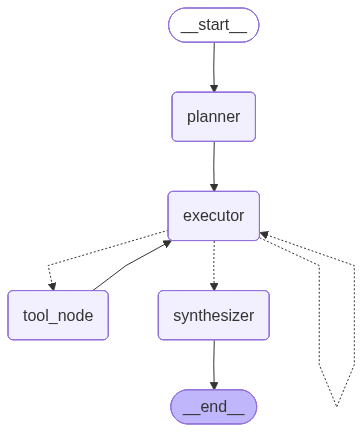

In [238]:
graph = StateGraph(PlanExecute)

graph.add_node("planner", planner)
graph.add_node("executor", executer)
graph.add_node("tool_node", tool_node)
graph.add_node("synthesizer", synthesizer)

graph.add_edge(START, "planner")
graph.add_edge("planner", "executor")
graph.add_conditional_edges("executor", condition_check, {'executor' : 'executor', 'tool_node' : 'tool_node', 'synthesizer' : "synthesizer"})
graph.add_edge("tool_node", "executor")
graph.add_edge("synthesizer", END)

workflow = graph.compile()
workflow


In [ ]:
workflow.invoke({'goal' : "What is the population of th country where Mt. Everest is situated at?"})

### Planner ---> Executor ----> Verifier

We can use the PEV architecture by linking the verifier with after the synthesizer for verifying whether the executor(s) worked with the plan and executed each task successfully with the optimized answer